#### Adam Klie<br>05/07/2020
# Perform core microbiome analyses in Qiime2
1. Taxonomic classification
2. Rarefaction plots
3. Core diversity
4. Diffential abundance
5. Compositionally aware diversity
6. Sample classification

In [11]:
import os
import qiime2
import warnings
warnings.filterwarnings('ignore')
from qiime2.plugins import feature_table, taxa, diversity, songbird, metadata, deicode, emperor, qurro, sample_classifier

## Directory set-up and data loading

In [12]:
# Data and results directories
data_dir = '../data/full/2020_05_15'
results_dir = '../results/full/2020_05_15'

In [13]:
# Specify already created results directories
tax_dir = '{}/taxonomy'.format(results_dir)
table_dir = '{}/feature_tables'.format(results_dir)
tree_dir = '{}/fragment_insertion'.format(results_dir)

In [14]:
# Specify new result directories
diversity_dir = '{}/diversity'.format(results_dir)
if not os.path.exists(diversity_dir): 
    os.makedirs(diversity_dir)
    
diff_dir = '{}/differential_abundance'.format(results_dir)
if not os.path.exists(diff_dir): 
    os.makedirs(diff_dir)
    
class_dir = '{}/sample_classification'.format(results_dir)
if not os.path.exists(class_dir): 
    os.makedirs(class_dir)

In [15]:
# Load feature table and meta_data
f_table = qiime2.Artifact.load('{}/insertion-table.qza'.format(table_dir))
meta_data = qiime2.Metadata.load('{}/metadata.tsv'.format(data_dir)) 

In [16]:
# Filter meta_data for faster plotting
filtered_meta_data = qiime2.Metadata(meta_data.to_dataframe()[["age_corrected", "sex", "body_site", 
                                                               "sample_type", "bmi_corrected", "exercise_frequency", 
                                                               "country", "race",  "diet_type"]])

## Taxonomy analysis
 - Inputs: 
     - insertion-table.qza (FeatureData[Frequency] artifact)
     - bespoke-taxonomy.qza (FeatureData[Taxonomy] artifact)
     - metadata.tsv (tab seperated table)
 - Outputs: 
     - taxa-bar-plot.qzv (Visualization)
 - Plugins: 
     - taxa

In [17]:
# Load taxonomy artifact
taxonomic_class = qiime2.Artifact.load('{}/bespoke-taxonomy.qza'.format(tax_dir))

In [18]:
# Generate barplot of taxa
taxonomic_class_vis = taxa.visualizers.barplot(table=f_table,
                                               taxonomy=taxonomic_class,
                                               metadata=meta_data)
#taxonomic_class_vis.visualization

In [19]:
# Save the barplot as visualization
taxonomic_class_vis.visualization.save('{}/taxa-bar-plot.qzv'.format(tax_dir))

'../results/full/2020_05_15/taxonomy/taxa-bar-plot.qzv'

## Rarefaction plots
 - Inputs: 
     - insertion-table.qza (FeatureData[Frequency] artifact)
     - sepp-tree.qza (Phylogeny[Rooted] artifact)
     - metadata.tsv (tab seperated table) -- highly recommend using filtered metadata here
 - Outputs: 
     - alpha-rarefaction.qzv (Visualization)
 - Plugins: 
     - diversity

In [20]:
# Load the insertion tree
tree = qiime2.Artifact.load('{}/sepp-tree.qza'.format(tree_dir))

In [ ]:
# Create rarefaction plots, takes about 4 minutes with ~30 samples and 9 metadata columns
alpha_rarefaction_vis = diversity.visualizers.alpha_rarefaction(table=f_table,
                                                                max_depth=10000,
                                                                phylogeny=tree,
                                                                metadata=filtered_meta_data)
#alpha_rarefaction_vis.visualization

In [ ]:
# Save the visualization
alpha_rarefaction_vis.visualization.save('{}/alpha-rarefaction.qzv'.format(diversity_dir))

## Core diversity
 - Inputs: 
     - insertion-table.qza (FeatureData[Frequency] artifact)
     - sepp-tree.qza (Phylogeny[Rooted] artifact)
     - metadata.tsv (tab seperated table) -- highly recommend using filtered metadata here
 - Outputs: 
     - rarefied-table.qza (FeatureTable[Frequency]
     - rarefied-table.qzv (Visualization)
     - shannon-vector.qza SampleData[AlphaDiversity]
     - faith-pd-vector.qza SampleData[AlphaDiversity]
     - faith-pd-group-significance.qzv (Visualization)
     - uw-unifrac-exercise-significance.qzv (Visualization)
     - uw-unifrac-emperor.qzv (Visualization)
 - Plugins: 
     - diversity
     - feature-table

In [26]:
# Depth to rarefy to, will lose all samples below this depth and sample from those above
depth = 5000

In [27]:
# Perform core diversity analysis
core_diversity = diversity.pipelines.core_metrics_phylogenetic(table=f_table,
                                                               phylogeny=tree,
                                                               sampling_depth=depth,
                                                               metadata=filtered_meta_data,
                                                               n_jobs=8)

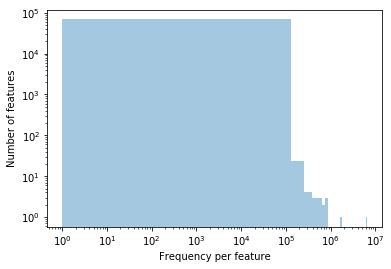

In [28]:
# Visualize the rarefied feature table used for analysis
rarefied_table_vis = feature_table.visualizers.summarize(table=core_diversity.rarefied_table, 
                                                         sample_metadata=filtered_meta_data)

In [29]:
# Save vectors and rarefied table
core_diversity.rarefied_table.save('{}/rarefied-table.qza'.format(table_dir))
rarefied_table_vis.visualization.save('{}/rarefied-table.qzv'.format(table_dir))
core_diversity.shannon_vector.save('{}/shannon-vector.qza'.format(diversity_dir))
core_diversity.faith_pd_vector.save('{}/faith-pd-vector.qza'.format(diversity_dir))
core_diversity.unweighted_unifrac_distance_matrix.save('{}/uw-unifrac-distance-matrix.qza'.format(diversity_dir))

'../results/full/2020_05_15/diversity/uw-unifrac-distance-matrix.qza'

### A. Alpha diversity significance testing
As recommended by Bod, test alpha significance for shannon diversity and faith's pd
 - Input
     - shannon-vector.qza (SampleData[AlphaDiversity])
     - faith-pd-vector.qza (SampleData[AlphaDiversity])
 - Output
     - shannon-group-significance.qzv (Visualization)
     - faith-pd-group-significance.qzv (Visualization)
 - Plugin
     - diversity

In [30]:
# Test and visualize shannon diversity for group significance
shannon_div = diversity.visualizers.alpha_group_significance(alpha_diversity=core_diversity.shannon_vector, 
                                                             metadata=filtered_meta_data)
#shannon_div.visualization

In [31]:
# Test and visualize faith's pd diversity for group significance
faiths_div = diversity.visualizers.alpha_group_significance(alpha_diversity=core_diversity.faith_pd_vector, metadata= filtered_meta_data)
#faiths_div.visualization

In [32]:
# Save significance visualizations
shannon_div.visualization.save('{}/shannon-group-significance.qzv'.format(diversity_dir))
faiths_div.visualization.save('{}/faith-pd-group-significance.qzv'.format(diversity_dir))

'../results/full/2020_05_15/diversity/faith-pd-group-significance.qzv'

### B. Beta diversity significance testing
As recommended by Bod, test beta diversity significance using unweighted unifrac and visualize emperor plor
 - Input
     - uw-unifrac-distance-matrix.qza (DistanceMatrix % Properties('phylogenetic'))
     - metadata.tsv (tab seperated table)
 - Output
     - uw-unifrac-exercise-significance/qzv (Visualization)
     - uw-unifrac-emperor.qzv (Visualization)
 - Plugin
     - diversity

In [33]:
# Remove '/' in exercise column values (https://forum.qiime2.org/t/plugin-error-from-diversity-alpha-rarefaction/4548/4)
tmp_df = filtered_meta_data.to_dataframe()
tmp_df['exercise_frequency'] = tmp_df['exercise_frequency'].map(lambda x: str(x).replace('/', ' a '))
filtered_meta_data = qiime2.Metadata(tmp_df)

In [34]:
# Test and visualize unweighted unifrac for group significance
uw_unifrac_div = diversity.visualizers.beta_group_significance(core_diversity.unweighted_unifrac_distance_matrix,
                                                               metadata=filtered_meta_data.get_column('exercise_frequency'),
                                                               pairwise=True)
#uw_unifrac_div.visualization

<Figure size 432x288 with 0 Axes>

In [35]:
# Visualize emperoro plot of unweighted unifrac
#core_diversity.unweighted_unifrac_emperor

In [36]:
# Save the group significance and emperor visualizations
uw_unifrac_div.visualization.save('{}/uw-unifrac-exercise-significance.qzv'.format(diversity_dir))
core_diversity.unweighted_unifrac_emperor.save('{}/uw-unifrac-emperor.qzv'.format(diversity_dir))

'../results/full/2020_05_15/diversity/uw-unifrac-emperor.qzv'

### C. Beta diversity significance testing with confounders using ADONIS
As recommended by Bod, test beta diversity significance using ADONIS for confounders
 - Input
     - uw-unifrac-distance-matrix.qza
 - Output
     - adonis-exercise-significance.qzv
 - Plugin
     - diversity
 - TODO
     - Decide a formula
 - Help

In [37]:
# Perform covariate aware PERMANOVA
adonis_vis = diversity.visualizers.adonis(distance_matrix=core_diversity.unweighted_unifrac_distance_matrix,
                                          metadata=filtered_meta_data,
                                          formula="exercise_frequency+sex")
#adonis_vis.visualization

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: run_adonis.R /tmp/tmpuooe6jqw/dm.tsv /tmp/tmpuooe6jqw/md.tsv exercise_frequency+sex 999 1 /tmp/qiime2-temp-bbdin8cz/adonis.tsv



FileNotFoundError: [Errno 2] No such file or directory: 'run_adonis.R': 'run_adonis.R'

In [ ]:
# Save the visualization
adonis_vis.visualization.save('{}/adonis-exercise-significance.qzv'.format(diversity_dir))

### D. Compositionally aware beta diversity using DEICODE 
 - Input
     - insertion-table.qza
 - Output
     - deicode-biplot.qza
     - deicode-distance-matrix.qza
     - deicode-emperor.qzv
     - deicode-exercise-significance.qzv
 - Plugins
     - deicode
     - diversity
 - TODO
     - 
 - Help
     - https://library.qiime2.org/plugins/deicode/19/
     - https://github.com/biocore/DEICODE
     - https://forum.qiime2.org/t/robust-aitchison-pca-beta-diversity-with-deicode/8333
     - https://nbviewer.jupyter.org/github/biocore/DEICODE/blob/master/ipynb/tutorials/moving-pictures.ipynb
     - https://nbviewer.jupyter.org/github/biocore/DEICODE/blob/master/ipynb/tutorials/moving-pictures-standalone-cli-and-api.ipynb

In [38]:
# Make a deicode subdirectory
deicode_dir = '{}/deicode'.format(diversity_dir)
if not os.path.exists(deicode_dir): 
    os.makedirs(deicode_dir)

In [39]:
# Run robust Atchison PCA
deicode_result = deicode.methods.auto_rpca(table=f_table)

In [40]:
# Visualize the PCoA biplot generated
feature_meta_data = taxonomic_class.view(qiime2.Metadata)
deicode_vis = emperor.visualizers.biplot(biplot=deicode_result.biplot, 
                                         sample_metadata=filtered_meta_data, 
                                         feature_metadata=feature_meta_data)
#deicode_vis.visualization

In [41]:
# Perform PERMANOVA on exercise frequency
deicode_sig = diversity.visualizers.beta_group_significance(distance_matrix=deicode_result.distance_matrix,
                                                           metadata=filtered_meta_data.get_column('exercise_frequency'),
                                                           method='permanova')
#deicode_sig.visualization

<Figure size 432x288 with 0 Axes>

In [42]:
# Save results and visualization
deicode_result.biplot.save('{}/deicode-biplot.qza'.format(deicode_dir))
deicode_result.distance_matrix.save('{}/deicode-distance-matrix.qza'.format(deicode_dir))
deicode_vis.visualization.save('{}/deicode-emperor.qzv'.format(deicode_dir))
deicode_sig.visualization.save('{}/deicode-exercise-significance.qzv'.format(deicode_dir))

'../results/full/2020_05_15/diversity/deicode/deicode-exercise-significance.qzv'

## Calculating differential abundance with Songbird
 - Input
     - insertion-table.qza (FeatureTable[Frequency])
     - metadata.tsv
     - formula (String)
 - Output
     - regression-stats.qza (SampleData[SongbirdStats])
     - regression-stats.qzv (Visualization)
     - differentials.qza (FeatureData[Differential])
     - differentials.qzv (Visualization)
 - TODO
     - When running full dataset, will need fine tune error curves
     - Will need to decide exactly what formula I want (necessary covariates for baseline, add exercise for test
     - Question we are trying to answer is does adding exercise_frequency contribute to taxa abundance prediction
     - Fully understand differential abundances table
 - Help
     - https://github.com/biocore/songbird/
     - https://github.com/biocore/songbird/issues/126
     - https://github.com/knightlab-analyses/reference-frames

In [43]:
# Model with exercise_frequency as covariate
songbird_result = songbird.methods.multinomial(table=f_table,
                                               metadata=filtered_meta_data,
                                               formula="exercise_frequency",
                                               epochs=1000,
                                               differential_prior=0.1,
                                               summary_interval=1)



Instructions for updating:
Use `tf.random.categorical` instead.

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where






  0%|          | 0/1385000 [00:00<?, ?it/s]

100%|██████████| 1385000/1385000 [47:13<00:00, 488.76it/s]


In [44]:
# Null model
null_result = songbird.methods.multinomial(table=f_table,
                                           metadata=filtered_meta_data,
                                           formula="1",
                                           epochs=1000,
                                           differential_prior=0.1,
                                           summary_interval=1)

100%|██████████| 1385000/1385000 [30:05<00:00, 766.93it/s]


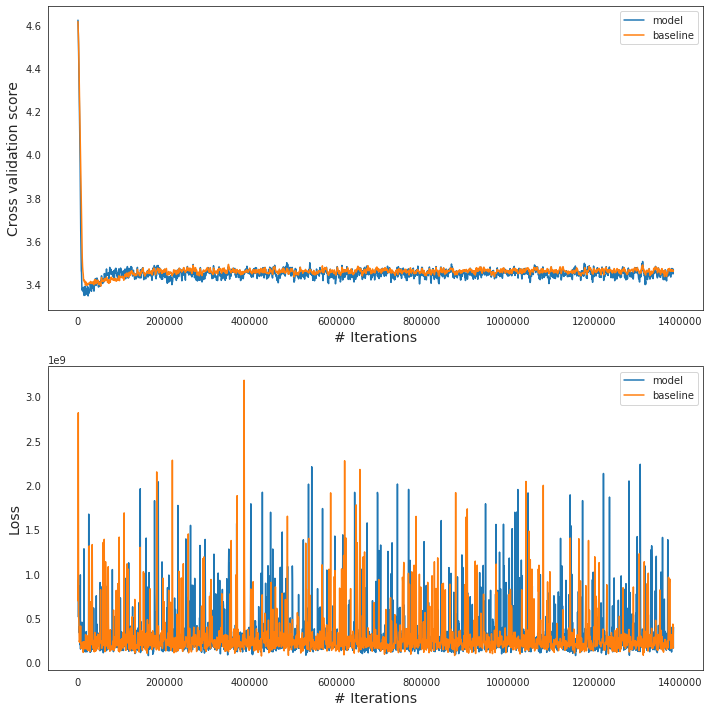

In [45]:
# Visualize error curves for baseline vs model
songbird_vis = songbird.visualizers.summarize_paired(regression_stats=songbird_result.regression_stats, 
                                                     baseline_stats=null_result.regression_stats)
#songbird_vis.visualization

In [46]:
# Visualize the differential abundances via a table
differentials = metadata.visualizers.tabulate(songbird_result.differentials.view(qiime2.Metadata))
#differentials.visualization

In [47]:
# Save error plots and differentials
songbird_result.regression_stats.save('{}/regression-stats'.format(diff_dir))
songbird_vis.visualization.save('{}/regression-stats'.format(diff_dir))
songbird_result.differentials.save('{}/differentials'.format(diff_dir))
differentials.visualization.save('{}/differentials'.format(diff_dir))

'../results/full/2020_05_15/differential_abundance/differentials.qzv'

## Visualizing differential abundance with Qurro
 - Input
     - deicode-distance-matrix.qza ()
     - differentials.qza ()
 - Output
     - qurro-deicode-plot.qzv
     - qurro-songbird-plot.qzv
 - Plugin
     - qurro
 - TODO
     - Better understand what I can do with this, may be more use case specific
 - Help
     - https://github.com/biocore/qurro
     - https://nbviewer.jupyter.org/github/biocore/qurro/blob/master/example_notebooks/moving_pictures/moving_pictures.ipynb

In [48]:
# DEICODE visualization
qurro_deicode = qurro.visualizers.loading_plot(deicode_result.biplot,
                              table=f_table,
                              sample_metadata=filtered_meta_data,
                              feature_metadata=feature_meta_data)
#qurro_deicode.visualization

66535 feature(s) in the BIOM table were not present in the feature rankings.
These feature(s) have been removed from the visualization.
18245 sample(s) in the sample metadata file were not present in the BIOM table.
These sample(s) have been removed from the visualization.


In [49]:
# Songbird visualization
qurro_songbird = qurro.visualizers.differential_plot(ranks=songbird_result.differentials,
                                   table=f_table,
                                   sample_metadata=filtered_meta_data,
                                                    feature_metadata= feature_meta_data)
#qurro_songbird.visualization

80835 feature(s) in the BIOM table were not present in the feature rankings.
These feature(s) have been removed from the visualization.
18245 sample(s) in the sample metadata file were not present in the BIOM table.
These sample(s) have been removed from the visualization.


In [50]:
# Save the two qurro visualiztions
qurro_deicode.visualization.save('{}/qurro-deicode-plot.qzv'.format(diff_dir))
qurro_deicode.visualization.save('{}/qurro-songbird-plot.qzv'.format(diff_dir))

'../results/full/2020_05_15/differential_abundance/qurro-songbird-plot.qzv'

## Sample classification
 - Input
     - insertion-table.qza
     - metadata.tsv
 - Output
     - 
 - Plugins
     - sample-classifier
 - TODO
     - collapsed taxonomy feature table
 - Help

<Figure size 432x288 with 0 Axes>

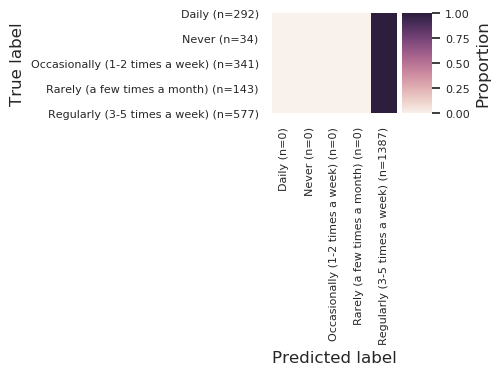

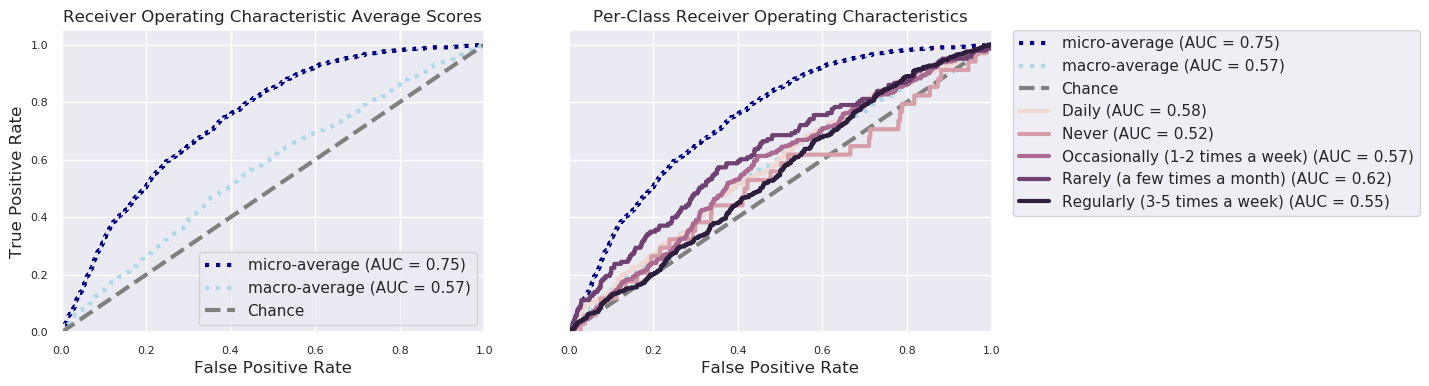

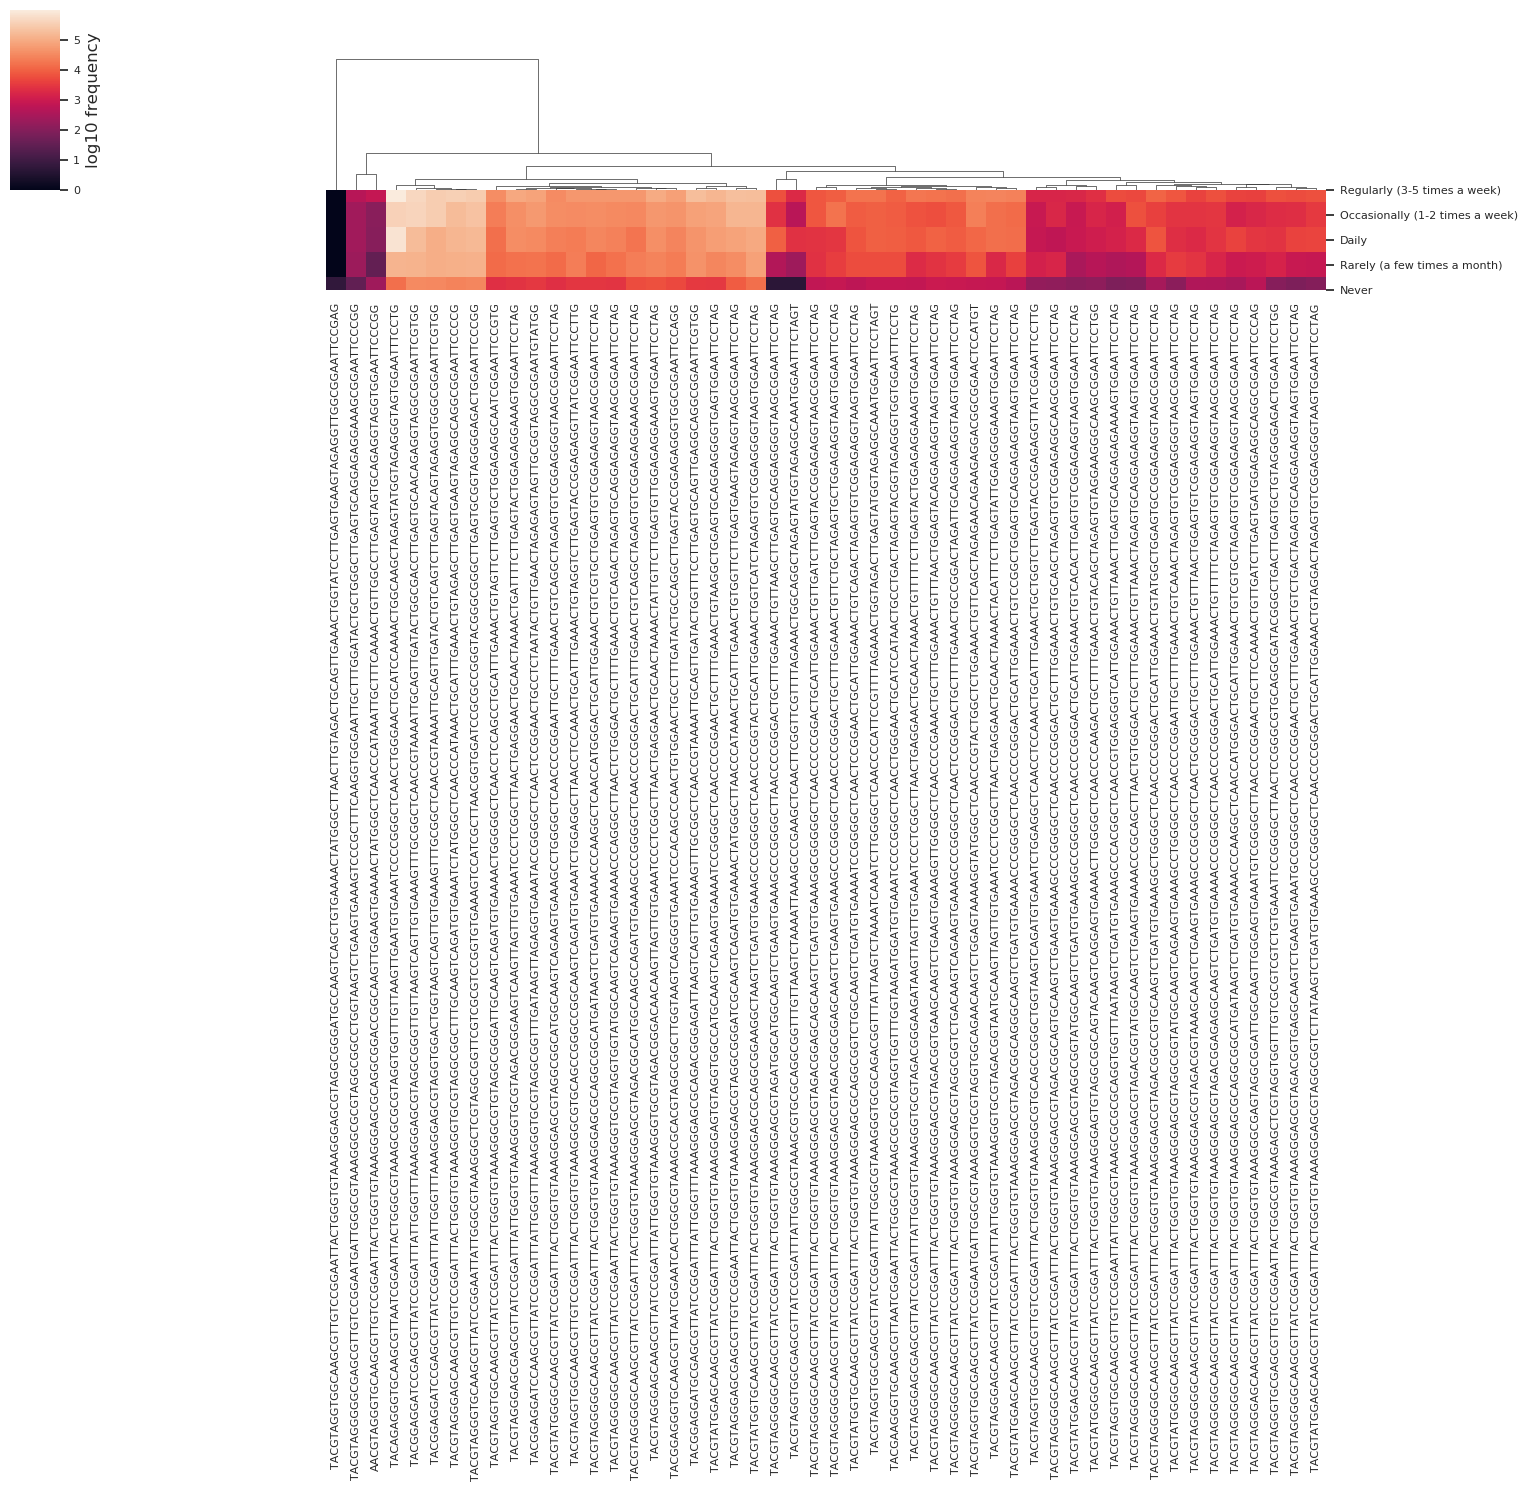

In [51]:
# Train a sample classifier
sample_class = sample_classifier.pipelines.classify_samples(table=f_table,
                                            metadata=filtered_meta_data.get_column('exercise_frequency'),
                                            estimator='RandomForestClassifier',
                                            n_estimators=20,
                                            parameter_tuning=True,
                                            optimize_feature_selection=True,
                                            random_state=13,
                                            missing_samples='ignore')

In [52]:
# Create visualizations
pred_vis = metadata.visualizers.tabulate(sample_class.predictions.view(qiime2.Metadata))
prob_vis = metadata.visualizers.tabulate(sample_class.probabilities.view(qiime2.Metadata))
importance_vis = metadata.visualizers.tabulate(sample_class.feature_importance.view(qiime2.Metadata))

In [53]:
# Save visualiztions
pred_vis.visualization.save('{}/predictions.qzv'.format(class_dir))
prob_vis.visualization.save('{}/probabilities.qzv'.format(class_dir))
importance_vis.visualization.save('{}/feature-importance.qzv'.format(class_dir))
sample_class.accuracy_results.save('{}/accuracy-results.qzv'.format(class_dir))
sample_class.heatmap.save('{}/heatmap.qzv'.format(class_dir))
sample_class.model_summary.save('{}/model_summary.qzv'.format(class_dir))

'../results/full/2020_05_15/sample_classification/model_summary.qzv'

In [54]:
# Save artifacts
sample_class.predictions.save('{}/predictions.qza'.format(class_dir))
sample_class.probabilities.save('{}/probabilities.qza'.format(class_dir))
sample_class.feature_importance.save('{}/feature-importance.qza'.format(class_dir))
sample_class.sample_estimator.save('{}/sample_estimator.qza'.format(class_dir))

'../results/full/2020_05_15/sample_classification/sample_estimator.qza'